In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import joblib

# EDA

Location from where the tweet was made isn't relevant to the tweet being about disaster. Hence, I dropped the coloumn which also makes the model simpler. I filled keywords as none if there wasn't any data

In [2]:
data = pd.read_csv("data	rain.csv")
data = data.drop(["location"],axis = 1)

data.fillna("none",inplace=True)
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7613 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


(7613, 4)

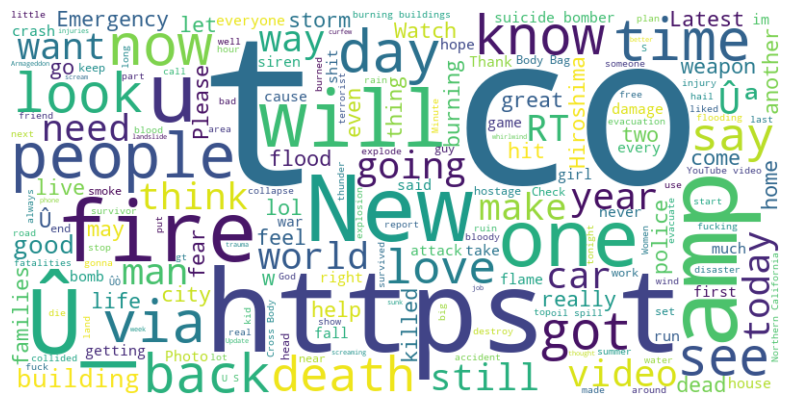

In [3]:
text = ' '.join(data['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Preprocessing

This means there are many links in text data. We remove them as they are irrelevant. I'm also removing punctuation, special characters, and numbers using regex.


Note: # and @ are kept in the dataset as these are relevant in the case of twitter tweets.

In [4]:
def clean_text(text):
  text= text.lower()
  # Remove Links
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  # Replace ? or ! with a whitespace
  text = re.sub(r'[?!]', ' ', text)
  #Remove Punc. numbers and special char.
  text = re.sub(r'[^a-zA-Z\s#@]', '', text)
  #Whitespace handling
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()

  return text

data["text"] = data["text"].apply(clean_text)

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenization and stop word removal
    tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=False)
    words = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_words = [word for word in words if word not in stop_words]

    '''# Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]'''

    # Lemmatization (using spaCy for efficiency)
    doc = nlp(" ".join(filtered_words))
    lemmatized_words = [token.lemma_ for token in doc]

    return " ".join(lemmatized_words)


data['text'] = data['text'].apply(preprocess_text)

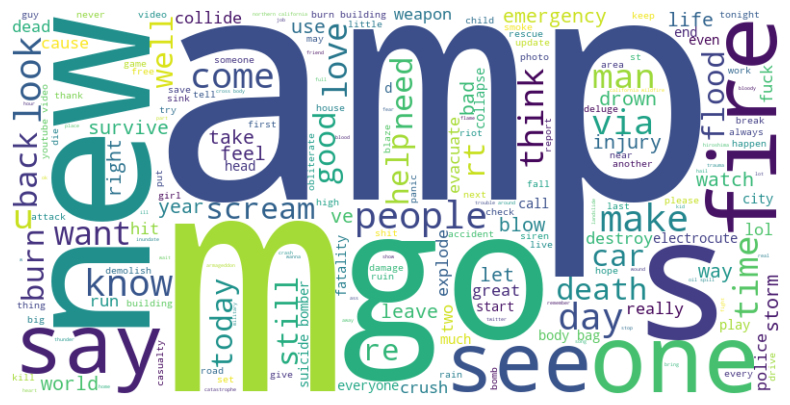

In [7]:
text = ' '.join(data['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The words "amp", "m" and "s" are derived from &amp, I'm and 's words. These are also stop words hence i remove them. I defined a new preprocess_text function that includes amp, m and s in stopwords and removes them from the dataset.

Also, I'll use TweetTokenizer to preserve tags and mentions(# and @)

In [8]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenization and stop word removal
    tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=False)
    words = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.add('amp')
    stop_words.add('m')
    stop_words.add('s')
    filtered_words = [word for word in words if word not in stop_words]

    '''# Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]'''

    # Lemmatization (using spaCy for efficiency)
    doc = nlp(" ".join(filtered_words))
    lemmatized_words = [token.lemma_ for token in doc]

    return " ".join(lemmatized_words)

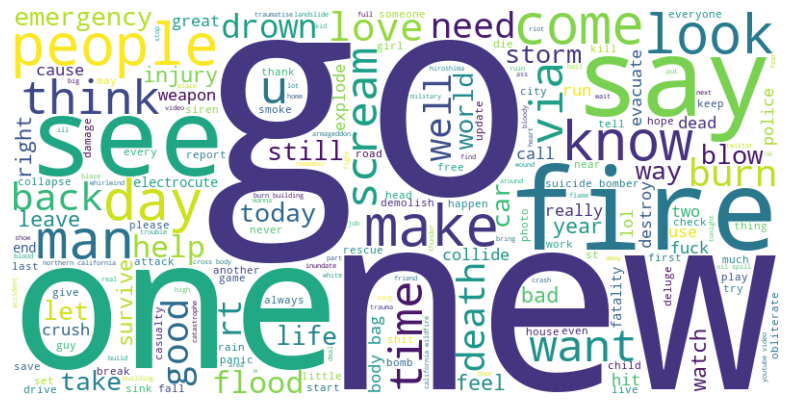

In [9]:
data["text"] = data["text"].apply(preprocess_text)

text = ' '.join(data['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
data["text"][:100]

0            deed reason # earthquake may allah forgive
1                 forest fire near la ronge sask canada
2     resident ask shelter place notify officer evac...
3     people receive # wildfire evacuation order cal...
4     get send photo ruby # alaska smoke # wildfire ...
                            ...                        
95    mile backup southaccident block right lane exi...
96    accident change life help determine option fin...
97    # break deadly motorcycle car accident happen ...
98                            @flowri marinade accident
99    car even week get fucking car accident mfs fuc...
Name: text, Length: 100, dtype: object

# Feature Extraction

Note: Keywords weren't used as a feature as they were giving worse performance to the model.

In [11]:
tfidf_vectorizer = TfidfVectorizer()
text_features = tfidf_vectorizer.fit_transform(data["text"])

print("Text Features Shape:", text_features.shape)

Text Features Shape: (7613, 14511)


# Model Building

In [12]:
X_train, X_test, y_train, y_test = train_test_split(text_features, data["target"], test_size=0.2, random_state=42)

In [40]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000,C=10, penalty='l2')
log_reg.fit(X_train, y_train)

# SVM
svm = SVC(kernel='rbf', C=2, gamma="scale",probability=True)
svm.fit(X_train, y_train)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [35]:
lst = [1,2]
lst.extend([3])
print(lst)

[1, 2, 3]


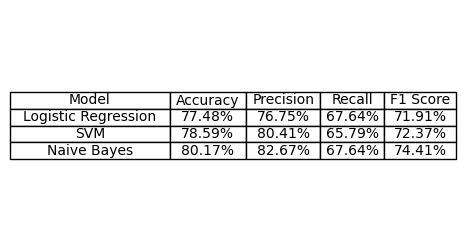

In [43]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    lst = []
    if model == "log_reg":
        lst.append(log_reg)
    lst.append(f"{accuracy_score(y_test, y_pred)*100:.2f}%")
    lst.append(f"{precision_score(y_test, y_pred)*100:.2f}%")
    lst.append(f"{recall_score(y_test, y_pred)*100:.2f}%")
    lst.append(f"{f1_score(y_test, y_pred)*100:.2f}%")

    return lst

# Creating a table to display results
columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
log_reg_res = ["Logistic Regression"]
log_reg_res.extend(evaluate_model(log_reg, X_test, y_test))

svm_res = ["SVM"]
svm_res.extend(evaluate_model(svm, X_test, y_test))

nb_res = ["Naive Bayes"]
nb_res.extend(evaluate_model(nb, X_test, y_test))

data = [
    log_reg_res,
    svm_res,
    nb_res
]
# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 3))  # Adjust size as needed
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=data, colLabels=columns, cellLoc="center", loc="center")

# Customize table appearance (optional)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

# Show the plot
plt.show()


# HyperParameter Tuning

In [17]:
# Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10,20,30,40,50]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)
print("Best Parameters for Logistic Regression:", grid_lr.best_params_)

# SVM

param_grid_svm = {'C': [1,2,3,4,5],'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='f1')
grid_svm.fit(X_train, y_train)
print("Best Parameters for SVM:", grid_svm.best_params_)

Best Parameters for Logistic Regression: {'C': 10}
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


# Visualization and Analysis

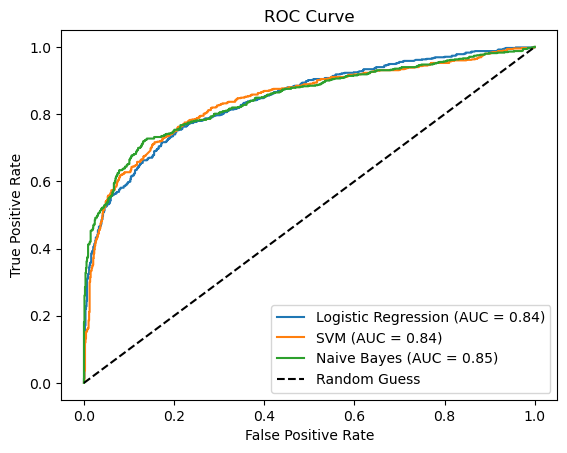

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(models, X_test, y_test):
    for model, label in models:
      y_pred_proba = model.predict_proba(X_test)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
      auc = roc_auc_score(y_test, y_pred_proba)
      plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


# Example for Logistic Regression
models = [
    (log_reg, "Logistic Regression"),
    (svm, "SVM"),
    (nb, "Naive Bayes")
]
plt.figure()
plot_roc_curve(models, X_test, y_test)
plt.show()


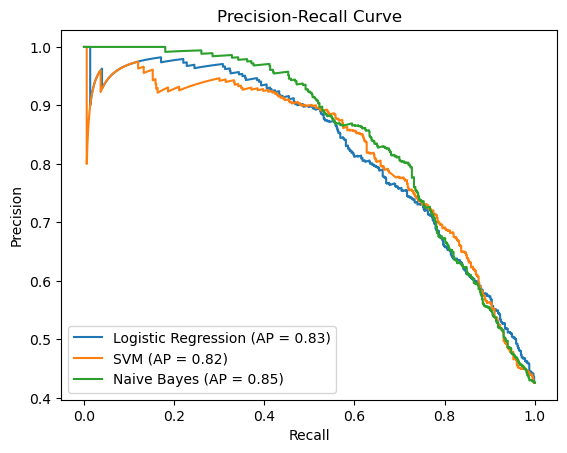

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(models, X_test, y_test):
    for model, label in models:
      y_pred_proba = model.predict_proba(X_test)[:, 1]
      precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
      avg_precision = average_precision_score(y_test, y_pred_proba)
      plt.plot(recall, precision, label=f'{label} (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

plt.figure()
plot_precision_recall_curve(models, X_test, y_test)
plt.show()


Let us see where the model misclassified the tweets.

In [20]:
# Get predictions
y_pred = svm.predict(X_test)

# Find indices of misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]

# Display misclassified examples
for i in misclassified_indices[:5]:
    print("Tweet:", data["text"][i])
    print(f"Actual Label: {y_test.iloc[i]}, Predicted Label: {y_pred[i]}")
    print("-" * 50)


Tweet: deed reason # earthquake may allah forgive
Actual Label: 1, Predicted Label: 0
--------------------------------------------------
Tweet: # flood # disaster heavy rain cause flash flooding street manitou colorado spring area
Actual Label: 1, Predicted Label: 0
--------------------------------------------------
Tweet: top hill see fire wood
Actual Label: 1, Predicted Label: 0
--------------------------------------------------
Tweet: love fruit
Actual Label: 0, Predicted Label: 1
--------------------------------------------------
Tweet: wayi eat shit
Actual Label: 0, Predicted Label: 1
--------------------------------------------------


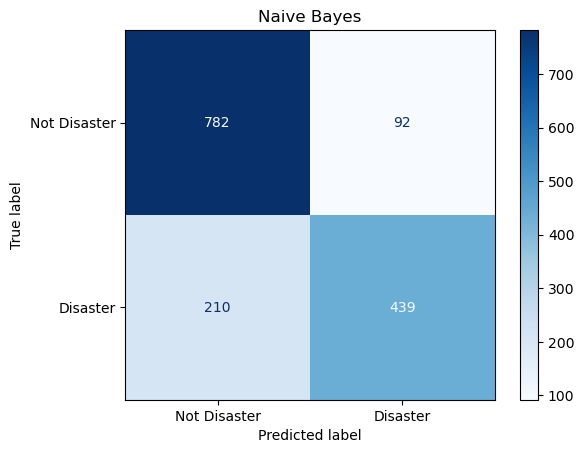

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(models, X_test, y_test):
    for model, title in models:
      y_pred = model.predict(X_test)
      cm = confusion_matrix(y_test, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Disaster', 'Disaster'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(models, X_test, y_test)


# Saving model

In [46]:
# Save SVM model and vectorizer
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl')
joblib.dump(svm, 'svm.pkl')

['svm.pkl']

In [53]:
test_data = pd.read_csv("data	est.csv")
test_data["text"] = test_data["text"].apply(clean_text)
test_data["text"] = test_data["text"].apply(preprocess_text)

y_pred = svm.predict(tfidf_vectorizer.transform(test_data["text"]))